# Algorytmy wykrywania odchyleń w danych

Zbiór danych wykorzystywany w projekcie to Wine Quality, wina czerwone, dostępny pod adresem https://archive.ics.uci.edu/ml/datasets/Wine+Quality.

Zawiera on 12 atrybutów oraz 1600 rekordów. Wszystkie atrybuty to atrybuty ciągłe:

• fixed acidity - wartości od 4,6 do 15,9

• volatile acidity – wartości od 0,12 do 1,58

• citric acid – wartości od 0 do 1

• residual sugar – wartości od 0,9 do 15,5

• chlorides - wartości od 0,012 do 0,611

• free sulfur dioxide – wartości od 1 do 72

• total sulfur dioxide – wartości od 6 do 289

• density - wartości od 0,99007 do 1

• pH - wartości od 2,74 do 4,01

• sulphates - wartości od 0,33 do 2

• alcohol – wartości od 8,4 do 14,9

• quality – wartości od 3 do 8

Zbiór nie posiada braków danych.

In [1]:
#wczytanie danych
import pandas as pd
file_id = '1tbF0ZhsWY-C4xP0uwv0Ih5sX6rwz5WlP'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, sep=";")

# Metoda pierwsza - IQR

W tej metodzie liczę wartości pierwszego i trzeciego kwartyla i na ich podsawie obliczam IQR, czyli rozstęp międzykwartylowy.

Wyznaczam następnie dolną i górną granicę, dane poniżej dolnej lub powyżej górnej granicy są odstające.

In [2]:
df1 = df.loc[0:, ['fixed acidity', 'volatile acidity']]
#pierwszy i trzeci kwartyl
q1 = df1.quantile(0.25)
q3 = df1.quantile(0.75)
#iqr
iqr = q3 - q1
#dolna i górna granica
low_margin = (q1 - 1.5 * iqr)
upp_margin = (q3 + 1.5 * iqr)
#suma danych odstających
num_of_outliers_L = (df1[iqr.index] < low_margin).sum()
num_of_outliers_U = (df1[iqr.index] > upp_margin).sum()
iqr_outliers = pd.DataFrame({'lower_margin':low_margin, 'upper_margin':upp_margin,'num_of_outliers_L':num_of_outliers_L, 'num_of_outliers_U':num_of_outliers_U})
iqr_outliers

,lower_margin,upper_margin,num_of_outliers_L,num_of_outliers_U
fixed acidity,3.950,12.350,0,49
volatile acidity,0.015,1.015,0,19


In [30]:
#indeksy danych odstających
outliers = df1[(df1[iqr.index] < low_margin) | (df1[iqr.index] > upp_margin)]
outliers = outliers.dropna(thresh=1)
outliers_iqr = outliers.index.array
print(*[int(x) for x in outliers.index.array])

38 94 120 126 127 134 199 205 206 243 244 264 294 328 338 339 347 353 359 363 364 366 374 381 391 394 409 429 440 442 446 470 472 509 510 516 538 544 548 553 554 555 557 559 560 564 565 596 599 601 603 611 652 672 680 690 700 705 710 724 811 814 899 1224 1261 1299 1312 1467


Dla atrybutów fixed acidity i volatile acidity otrzymałem łącznie 68 odchyleń.

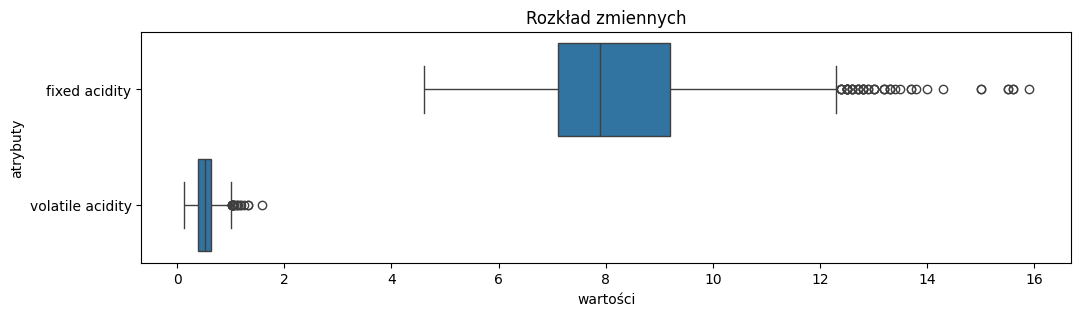

In [5]:
#wykres pudełkowy IQR
import matplotlib.pyplot as plt
import seaborn as sns
melted_wines_df = pd.melt(df1, value_vars=df1.columns, var_name='feature_name', value_name = 'wartości')
plt.figure(figsize=(12,3))
sns.boxplot(data = melted_wines_df, y = 'feature_name', x = 'wartości').set(title = 'Rozkład zmiennych', ylabel = 'atrybuty')
plt.show()

# Metoda druga - Local Outlier Factor

LOF to metoda oparta na gęstości danych. Porównuje ona gęstość punktu z gęstością jego sąsiadów.

Wynik zależny jest od wartości zmiennych n_neighbours (wymagana ilość sąsiadów) oraz contamination (odsetek wartości odstających)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from numpy import quantile, where, random

In [7]:
#ustalam wartości zmiennych
lof = LocalOutlierFactor(n_neighbors=20, contamination=.04)
df1 = df.loc[0:, ['fixed acidity', 'volatile acidity']]
#dopasowanie modelu do danych
predict = lof.fit_predict(df1)
#sprawdzam indeksy danych uznanych za dane odstające, czyli tych które otrzymały wynik -1
indexes = where(predict==-1)
outliers = df1.iloc[indexes]
outliers_lof1 = indexes[0]
print(len(outliers_lof1), ' odchyleń')
outliers_lof1

64  odchyleń


array([  38,   45,   64,   65,   94,  120,  126,  127,  182,  199,  234,
        239,  243,  244,  261,  270,  275,  296,  347,  350,  374,  381,
        391,  442,  454,  544,  553,  554,  555,  557,  633,  652,  672,
        684,  690,  700,  705,  710,  724,  756,  775,  795,  836,  837,
        861,  889,  899, 1037, 1040, 1120, 1126, 1143, 1189, 1230, 1261,
       1286, 1299, 1312, 1334, 1467, 1469, 1478, 1490, 1566])

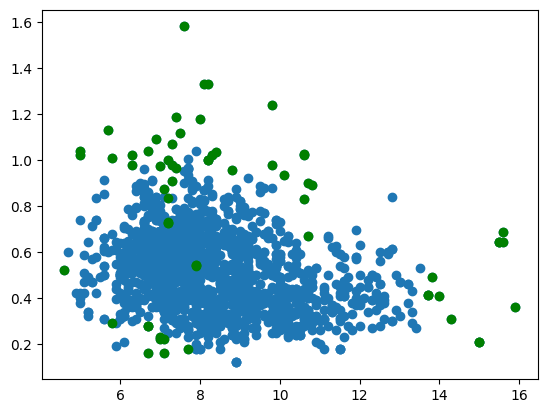

In [8]:
#przedstawienie anomalii na wykresie
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.scatter(outliers.iloc[:,0],outliers.iloc[:,1], color='green')
plt.show()

Ilość wartości odstających uzależniona jest od parametru contamination, w tym przypadku jest to 64 odchyleń. Wykonem teraz 2 kolejne próby ustalając inne wartośći parametrów.

64  odchyleń
[  38   45   46   95  120  126  127  134  160  199  234  239  243  244
  261  296  347  353  374  381  391  422  424  442  454  544  554  555
  557  633  638  652  659  672  684  690  700  705  710  724  732  735
  736  755  756  775  795  821  861  889  899 1012 1037 1040 1143 1261
 1286 1299 1312 1334 1467 1469 1478 1566]


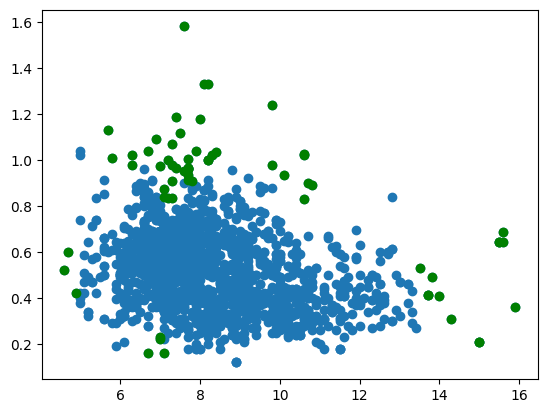

In [9]:
# LOF, inne parametry
lof = LocalOutlierFactor(n_neighbors=50, contamination=.04)
df1 = df1.loc[0:, ['fixed acidity', 'volatile acidity']]
predict = lof.fit_predict(df1)
indexes = where(predict==-1)
outliers = df1.iloc[indexes]
outliers_lof2 = indexes[0]
print(len(outliers_lof2), ' odchyleń')
print(outliers_lof2)
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.scatter(outliers.iloc[:,0],outliers.iloc[:,1], color='green')
plt.show()

Wartość parametr contamination i liczba ochyleń pozostała taka sama. Zwiększając wartość parametru n_neighbors zmieniły się jednak punkty uznane za ochylenia.

48  odchyleń
[  38   45   95  120  126  127  199  243  244  261  347  374  381  391
  422  424  442  544  554  555  557  633  652  672  684  690  700  705
  710  724  735  736  775  795  861  889  899 1012 1037 1040 1261 1286
 1299 1312 1467 1469 1478 1566]


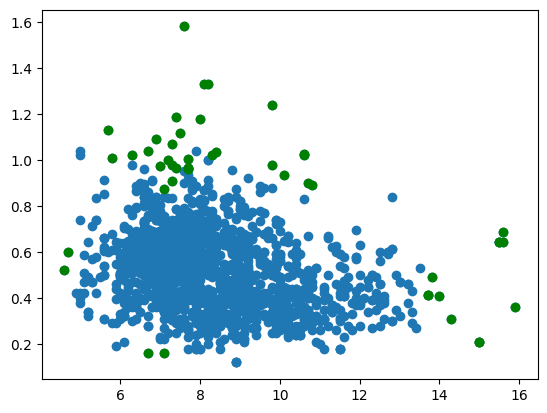

In [10]:
# LOF, inne parametry
lof = LocalOutlierFactor(n_neighbors=50, contamination=.03)
df1 = df1.loc[0:, ['fixed acidity', 'volatile acidity']]
predict = lof.fit_predict(df1)
indexes = where(predict==-1)
outliers = df1.iloc[indexes]
outliers_lof3 = indexes[0]
print(len(outliers_lof3), ' odchyleń')
print(outliers_lof3)
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.scatter(outliers.iloc[:,0],outliers.iloc[:,1], color='green')
plt.show()

W ostatniej próbie zmniejszyłem wartość parametru contamination względem poprzedniej próby. Teraz wykonam porówanie przeprowadzonych prób i znajdę wspólne odchylenia.

In [12]:
outliers_lof = set(outliers_lof1) & set(outliers_lof2) & set(outliers_lof3)
print('liczba wspólnych odchyleń: ', len(outliers_lof))
print(*[int(x) for x in outliers_lof])

liczba wspólnych odchyleń:  42
899 261 1286 775 391 652 1037 1040 1299 795 1566 544 672 1312 38 554 555 684 45 557 690 442 1467 700 1469 705 710 199 1478 724 347 861 1261 633 243 244 374 120 889 381 126 127


# Metoda trzecia - K-MEANS

K-means to algorytm grupujący dane w klastry (grupy). Dane najbardziej oddalone od centroidu (środka grupy) są uzanawne za odstające.

In [13]:
import random
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Grupowanie k-średnich, 3 grupy
df1 = df.loc[0:, ['fixed acidity', 'volatile acidity']]
kmeans = KMeans(n_clusters=3).fit(df1)
# atrybut cluster określa przynależność do grupy
df1['cluster'] = kmeans.labels_
print(df1.head())

   fixed acidity  volatile acidity  cluster
0            7.4              0.70        0
1            7.8              0.88        0
2            7.8              0.76        0
3           11.2              0.28        1
4            7.4              0.70        0


In [15]:
# środki skupień wyznaczone są w polu cluster_centers_:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['fixed acidity', 'volatile acidity'])
print(centers.iloc[:, 0:2])

   fixed acidity  volatile acidity
0       7.018015          0.565619
1      11.467490          0.426749
2       8.870000          0.516185


In [16]:
# obliczenie odległości od środka grupy
def distance_from_center(a, b, label):
    center_0 =  kmeans.cluster_centers_[label,0]
    center_1 =  kmeans.cluster_centers_[label,1]
    distance = np.sqrt((a - center_0) ** 2 + (b - center_1) ** 2)
    return np.round(distance, 3)
df1['label'] = kmeans.labels_
df1['distance'] = distance_from_center(df1['fixed acidity'], df1['volatile acidity'], df1['cluster'])

In [17]:
# Określam najbardziej odległe 50 punktów danych jako wartości odstające
outliers = list(df1.sort_values('distance', ascending=False).head(50).index)
outliers = df1[df1.index.isin(outliers)]
outliers_kmeans1 = outliers.index
print(len(outliers_kmeans1), ' odchyleń')
outliers_kmeans1

50  odchyleń


Index([  34,   45,   94,   95,  142,  144,  198,  230,  243,  244,  294,  328,
        347,  353,  374,  381,  391,  442,  444,  470,  509,  544,  553,  554,
        555,  557,  559,  588,  601,  603,  611,  652,  680,  695,  802,  821,
        916, 1111, 1114, 1157, 1228, 1270, 1300, 1316, 1321, 1377, 1475, 1477,
       1537, 1591],
      dtype='int64')

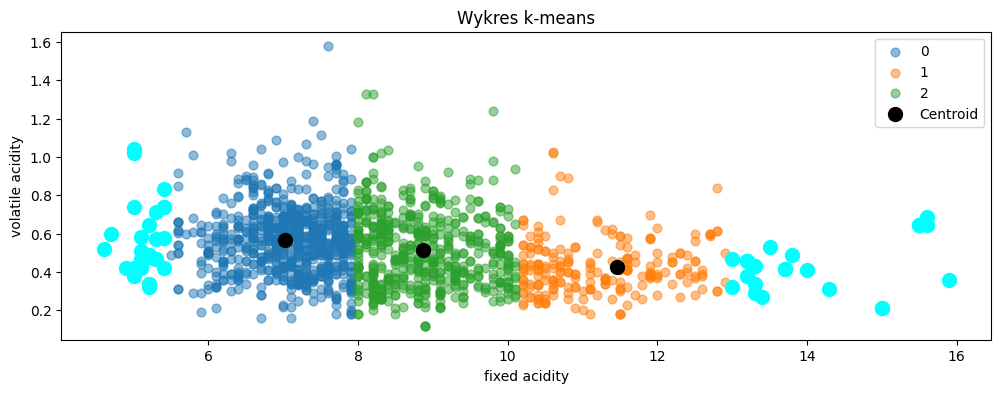

In [18]:
# wykres k-means, 4 grupy
plt.figure(figsize=(12,4))
for i in range(np.max(kmeans.labels_)+1):
    plt.scatter(df1[kmeans.labels_==i]['fixed acidity'], df1[kmeans.labels_==i]['volatile acidity'], label=i, alpha=0.5, s=40)
#odchylenia zazaczone są na jasnoniebieski kolor
plt.scatter(outliers['fixed acidity'], outliers['volatile acidity'], c='aqua', s=100)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], label='Centroid', c="black", s=100)
plt.title("Klastrowanie danych klientów metodą K-Means",size=20)
plt.xlabel("fixed acidity")
plt.ylabel("volatile acidity")
plt.title('Wykres k-means')
plt.legend()
plt.show()

Wykorzystująć metodę K-means najwięcej odchyleń uzyskałem wśród punktów o skrajnych wartościach atrybutu fixed acidity. Ilość odchyleń ustaliłem na 50.

50  odchyleń
Index([  34,   45,   94,   95,  142,  144,  230,  243,  244,  250,  272,  295,
        328,  342,  343,  347,  353,  374,  381,  391,  442,  518,  544,  553,
        554,  555,  556,  557,  558,  588,  652,  674,  676,  679,  695,  795,
        802,  815,  817,  821, 1109, 1114, 1157, 1220, 1221, 1228, 1270, 1300,
       1321, 1377],
      dtype='int64')


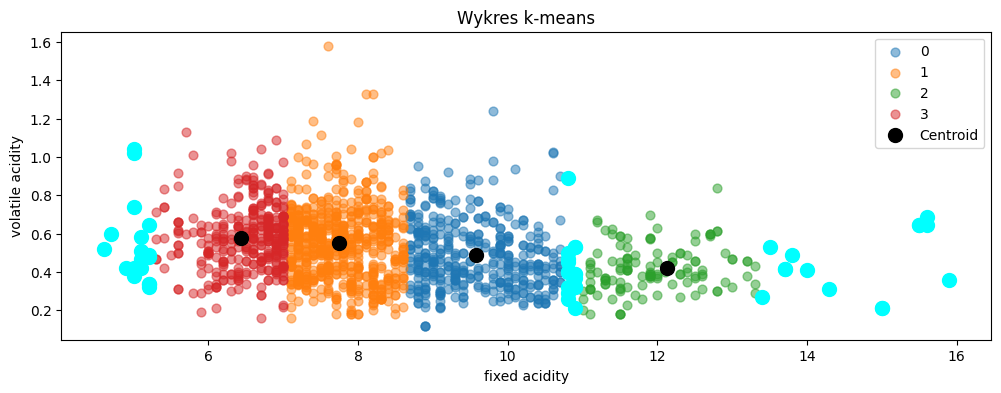

In [19]:
#2 k-means 4 grupy
df1 = df.loc[0:, ['fixed acidity', 'volatile acidity']]
kmeans = KMeans(n_clusters=4).fit(df1)
df1['cluster'] = kmeans.labels_
df1['label'] = kmeans.labels_
df1['distance'] = distance_from_center(df1['fixed acidity'], df1['volatile acidity'], df1['cluster'])
outliers = list(df1.sort_values('distance', ascending=False).head(50).index)
outliers = df1[df1.index.isin(outliers)]
outliers_kmeans2 = outliers.index
print(len(outliers_kmeans2), ' odchyleń')
print(outliers_kmeans2)

#wykres
plt.figure(figsize=(12,4))
for i in range(np.max(kmeans.labels_)+1):
    plt.scatter(df1[kmeans.labels_==i]['fixed acidity'], df1[kmeans.labels_==i]['volatile acidity'], label=i, alpha=0.5, s=40)
plt.scatter(outliers['fixed acidity'], outliers['volatile acidity'], c='aqua', s=100)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], label='Centroid', c="black", s=100)
plt.title("Klastrowanie danych klientów metodą K-Means",size=20)
plt.xlabel("fixed acidity")
plt.ylabel("volatile acidity")
plt.title('Wykres k-means')
plt.legend()
plt.show()

Zwiększenie liczby grup do 4 spowodowało nie zmieniło w sposób znaczący wyniku.

50  odchyleń
Index([  34,   45,   94,   95,  126,  127,  142,  144,  265,  294,  296,  328,
        335,  347,  353,  362,  374,  381,  391,  509,  544,  553,  584,  588,
        597,  601,  603,  611,  652,  672,  680,  690,  695,  699,  700,  705,
        710,  756,  802,  821,  889,  899, 1114, 1157, 1228, 1261, 1270, 1299,
       1312, 1321],
      dtype='int64')


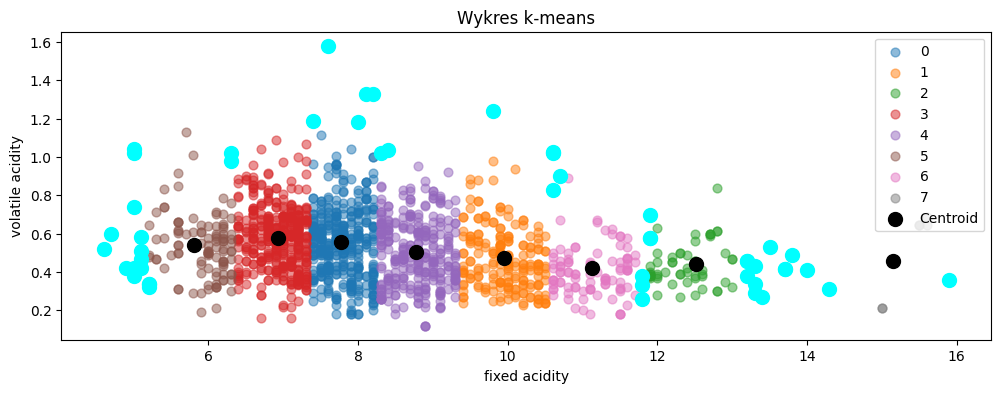

In [20]:
#3 k-means 5 grup
df1 = df.loc[0:, ['fixed acidity', 'volatile acidity']]
kmeans = KMeans(n_clusters=8).fit(df1)
df1['cluster'] = kmeans.labels_
df1['label'] = kmeans.labels_
df1['distance'] = distance_from_center(df1['fixed acidity'], df1['volatile acidity'], df1['cluster'])
outliers = list(df1.sort_values('distance', ascending=False).head(50).index)
outliers = df1[df1.index.isin(outliers)]
outliers_kmeans3 = outliers.index
print(len(outliers_kmeans3), ' odchyleń')
print(outliers_kmeans3)

#wykres
plt.figure(figsize=(12,4))
for i in range(np.max(kmeans.labels_)+1):
    plt.scatter(df1[kmeans.labels_==i]['fixed acidity'], df1[kmeans.labels_==i]['volatile acidity'], label=i, alpha=0.5, s=40)
plt.scatter(outliers['fixed acidity'], outliers['volatile acidity'], c='aqua', s=100)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], label='Centroid', c="black", s=100)
plt.title("Klastrowanie danych klientów metodą K-Means",size=20)
plt.xlabel("fixed acidity")
plt.ylabel("volatile acidity")
plt.title('Wykres k-means')
plt.legend()
plt.show()

Kolejne zwiększenie ilości grup do spowodowało pojawienie się odchyleń między centroidami numer 0 i 5. Obliczę teraz ilość wspólnych odchyleń wszystkich prób.

In [21]:
outliers_kmeans = set(outliers_kmeans1) & set(outliers_kmeans2) & set(outliers_kmeans3)
print('liczba wspólnych odchyleń: ', len(outliers_kmeans))
outliers_kmeans

liczba wspólnych odchyleń:  24


{34,
 45,
 94,
 95,
 142,
 144,
 328,
 347,
 353,
 374,
 381,
 391,
 544,
 553,
 588,
 652,
 695,
 802,
 821,
 1114,
 1157,
 1228,
 1270,
 1321}

Liczba wspólnych odchyleń wyniosła jedynie 17. W tym wypadku policzę wspólne odchylenia pomiędzy poszczególnymi próbami.

In [22]:
outliers_kmeans12 = set(outliers_kmeans1) & set(outliers_kmeans2)
print('liczba wspólnych odchyleń, próby 1 i 2: ', len(outliers_kmeans12))
print(sorted(outliers_kmeans12))

outliers_kmeans13 = set(outliers_kmeans1) & set(outliers_kmeans3)
print('liczba wspólnych odchyleń, próby 1 i 3: ', len(outliers_kmeans13))
print(sorted(outliers_kmeans13))

outliers_kmeans23 = set(outliers_kmeans2) & set(outliers_kmeans3)
print('liczba wspólnych odchyleń, próby 2 i 3: ', len(outliers_kmeans23))
print(sorted(outliers_kmeans23))

liczba wspólnych odchyleń, próby 1 i 2:  33
[34, 45, 94, 95, 142, 144, 230, 243, 244, 328, 347, 353, 374, 381, 391, 442, 544, 553, 554, 555, 557, 588, 652, 695, 802, 821, 1114, 1157, 1228, 1270, 1300, 1321, 1377]
liczba wspólnych odchyleń, próby 1 i 3:  30
[34, 45, 94, 95, 142, 144, 294, 328, 347, 353, 374, 381, 391, 509, 544, 553, 588, 601, 603, 611, 652, 680, 695, 802, 821, 1114, 1157, 1228, 1270, 1321]
liczba wspólnych odchyleń, próby 2 i 3:  24
[34, 45, 94, 95, 142, 144, 328, 347, 353, 374, 381, 391, 544, 553, 588, 652, 695, 802, 821, 1114, 1157, 1228, 1270, 1321]


Najbardziej podobne wyniki uzyskałem dla próby pierwszej i drugiej - 44 wspólych odchyleń z 50. Zwiększenie liczby grup do 5 spowodowało zmniejszenie ilości wpsólnych odchyleń.

In [23]:
outliers_kmeans = outliers_kmeans12

# Porównanie

Aby porównać wybrane metody obliczę ich wspólne odchylenia. Wykorzystam do tego odchylenia IQR, wspólne odchylenia dla trzech prób metody LOF oraz wspólne odchylenie dla pierwszych dwóch prób metody K-means.

Wspólne odchylenia IQR i LOF:

In [25]:
outliers_iqr_lof = set(outliers_iqr) & set(outliers_lof)
print('liczba wspólnych odchyleń, metody IQR i LOF: ', len(outliers_iqr_lof))
sorted_outliers = sorted(outliers_iqr_lof)
print(*[int(x) for x in sorted_outliers])

liczba wspólnych odchyleń, metody IQR i LOF:  28
38 120 126 127 199 243 244 347 374 381 391 442 544 554 555 557 652 672 690 700 705 710 724 899 1261 1299 1312 1467


Wspólne odchylenia IQR i K-means:

In [26]:
outliers_iqr_kmeans = set(outliers_iqr) & set(outliers_kmeans)
print('liczba wspólnych odchyleń, metody IQR i K-means: ', len(outliers_iqr_kmeans))
print(sorted(outliers_iqr_kmeans))

liczba wspólnych odchyleń, metody IQR i K-means:  16
[94, 243, 244, 328, 347, 353, 374, 381, 391, 442, 544, 553, 554, 555, 557, 652]


Wspólne odchylenia LOF i K-means:

In [27]:
outliers_lof_kmeans = set(outliers_lof) & set(outliers_kmeans)
print('liczba wspólnych odchyleń, metody LOF i K-means: ', len(outliers_lof_kmeans))
print(sorted(outliers_lof_kmeans))

liczba wspólnych odchyleń, metody LOF i K-means:  13
[45, 243, 244, 347, 374, 381, 391, 442, 544, 554, 555, 557, 652]


Wspólne odchylenia wszystkich metod:

In [29]:
outliers_3 = set(outliers_iqr) & set(outliers_lof) & set(outliers_kmeans)
print('liczba wspólnych odchyleń, wszystkie metody: ', len(outliers_3))
sorted_outliers3 = sorted(outliers_3)
print(*[int(x) for x in sorted_outliers3])

liczba wspólnych odchyleń, wszystkie metody:  12
243 244 347 374 381 391 442 544 554 555 557 652


Na podstawie otrzymanych wyników stwierdzam, że spośród wybranych metod, IQR oraz LOF mają najwięcej odchyleń wspólnych.


# Wnioski

Najbardziej różniąca się od pozostałych metoda to K-means. Jest to spowodowane tym, że K-means może być podatne na odchylenia. Wpływają one na położenie centroidów, przesuwając je w swoją stronę, a w skrajnych przypadkach mogą nawet mieć swój własny klaster, co może mieć zauważalny wpływ na ostateczny wynik.